## Step 0: Estimating Building Sizes

Real world building list can be generated using __parcel map__ shapefile downloaded from [data.detroitmi.gov](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf/data) by clicking the '_export_' button near upper right corner of the screen, and then select '_CSV_' option.

Each valid row contains a multipolygon constituted by a list of coordinates. From this information, we can construct a rectangle using lowerleft corner and upperright corner derived from the polygon. Each rectangle would then represent a building.

__Notes__:
+  The data files given from the course is slightly different from the posted coordiates at data.detroitmi.gov. (This is __The Right Thing__ since it protects privacy. However, this also means that we can not use the coordiates directly from website. Instead, one has to estimate building dimensions based solely on the given data from course materials.
+  shapefile python documentation can be found [here](https://pypi.python.org/pypi/pyshp)
+  Detroit parcel map shapefile can be cleaned with the help of this script (['test_valid_shp.py'](./test_valid_shp.py)).
+  After cleaning, bboxes was extracted using script ['define_buildings.py'](./define_buildings.py) with some functions defined in ['bbox.py'](./bbox.py). The generated building data was stored as a .csv file located at '../data/buildings.csv' 
+  Visualization of the boxes was realized by script ['draw_bboxes.py'](./draw_bboxes.py). [Basemap](http://basemaptutorial.readthedocs.io) library was used for this purpose.

## Generating data from PARCELS.csv for building info

One can in principle assume a grid to represent buildings. However, there are two problems with this approach:
1.  buildings can be of very different sizes.
2.  the density of buildings are not uniform.

Since we have access to building info from [data.detroitmi.gov](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf/data). The real world building info is extracted from that file in combination with the provided .csv files from the course to provide a more meaningful analysis.

In [161]:
import numpy as np
import pandas as pd

In [162]:
parcels = pd.read_csv("../data/Parcel_Map/PARCELS.csv")

/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (12,47,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [163]:
parcels.columns

Index(['the_geom', 'OBJECTID', 'Shape_STAr', 'PARCELNO', 'Shape_STLe', 'WARD',
       'DISTRICT', 'ECF', 'PROPADDR', 'PROPNO', 'PROPDIR', 'PROPSTR',
       'PROPZIP', 'TAXPAYER1', 'TAXPAYER2', 'TAXADDR', 'TAXCITY', 'TAXSTATE',
       'PREVPCLASS', 'TAXZIP', 'PROPCLASS', 'PROPSTATUS', 'TAXSTATUS',
       'PREVTSTATU', 'TOTALSQFT', 'TOTALACREA', 'FRONTAGE', 'DEPTH', 'USECODE',
       'HOMESTEAD', 'NEZ', 'CIBFLAREA', 'CIBBLDGNO', 'CIBOCC', 'CIBYRBUILT',
       'RESFLAREA', 'RESBLDGNO', 'RESOCC', 'RESSTYLE', 'RESYRBUILT',
       'ISIMPROVED', 'SALEPRICE', 'SALEDATE', 'AV', 'TV', 'SEV', 'LANDVALUE',
       'LANDMAP', 'XSTRNAME1', 'XSTRNAME2', 'RELATED', 'AKA', 'SUBDIVISIO',
       'SPECACT', 'LEGAL', 'RP'],
      dtype='object')

In [164]:
parcels = parcels[['the_geom', 'PARCELNO','PROPADDR']]
print("original number of parcels: %d" % parcels.shape[0])

original number of parcels: 384675


In [165]:
parcels.dropna(axis=0,inplace=True)
print("after dropna: %d" % parcels.shape[0])

after dropna: 384597


In [166]:
parcels.iloc[0,0]

'MULTIPOLYGON (((-83.04165895478116 42.329554868661866, -83.03929195571008 42.33057986836967, -83.03912395576653 42.33026786788393, -83.03901095566742 42.33005586809884, -83.03867595539081 42.329624868498854, -83.03841695545209 42.32929186848, -83.03804795627754 42.32881686840838, -83.0379439556402 42.32868386847111, -83.03834395568987 42.32849886867042, -83.0402839555524 42.327599868893444, -83.04063795566806 42.328051869036344, -83.04085495543352 42.32832886835788, -83.04083595526853 42.32833686885066, -83.04087895524218 42.32839186853662, -83.04089995520081 42.328385868700984, -83.04099495573118 42.32850586865732, -83.0409719547512 42.32851186854012, -83.04116295560775 42.328757868534744, -83.04159295493145 42.32929086810708, -83.04165895478116 42.329554868661866)))'

First column ('the\_geom') contains coordinates forming a polygon. For simplicity, we can derive a rectangule with lower left corner and upper right corner to represent the area.

In [167]:
parcels.reset_index(inplace=True)

In [168]:
geoms = parcels['the_geom'].astype(str).apply(lambda x: x.split())
geoms = geoms.apply(lambda x: x[1:])
geoms = geoms.apply(lambda x: [x[0].lstrip('[').lstrip('(')]+x[1:-1]+[x[-1].rstrip(']').rstrip(')')])

In [169]:
def extract_lons(list_of_geom):
    '''select longitudes from a list of multipolygon'''
    np_list_of_geom = np.array(list_of_geom)
    np_lons = np_list_of_geom[::2]
    if (not np_lons.size):
        return []
    np_lons = np.char.lstrip(np_lons,'(')
    np_lons = np.char.replace(np_lons,'EMPTY','Nan')
    np_lons = np_lons.astype(float)
    return np_lons

def extract_lats(list_of_geom):
    '''select latitudes from a list of multipolygon'''
    np_list_of_geom = np.array(list_of_geom)
    np_lats = np_list_of_geom[1::2]
    
    if (not np_lats.size):
        return []
    np_lats = np.char.rstrip(np_lats,',')
    np_lats = np.char.rstrip(np_lats,')')
    np_lats = np.char.replace(np_lats,'EMPTY','Nan')
    np_lats = np_lats.astype(float)
    return np_lats
        

In [170]:
parcels['lons'] = geoms.apply(lambda x: extract_lons(x))
parcels['lats'] = geoms.apply(lambda x: extract_lats(x))

In [171]:
parcels['llcrnrlon'] = parcels['lons'].apply(lambda x: min(x))
parcels['llcrnrlat'] = parcels['lats'].apply(lambda x: min(x))
parcels['urcrnrlon'] = parcels['lons'].apply(lambda x: max(x))
parcels['urcrnrlat'] = parcels['lats'].apply(lambda x: max(x))
parcels['lon'] = parcels['lons'].apply(lambda x: x.mean()) # center of rectangle
parcels['lat'] = parcels['lats'].apply(lambda x: x.mean()) # center of rectangle

In [172]:
parcels['addr'] = parcels['PROPADDR'].apply(lambda x: x.lower())

In [173]:
from matplotlib import pyplot as plt
%matplotlib inline

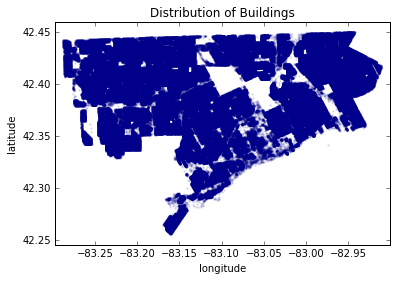

In [210]:
fig, ax = plt.subplots(1)
ax.scatter(parcels['lon'], parcels['lat'], s = 2, color='darkblue', alpha = 0.1)
ax.set_xlabel('longitude')
ax.set_xlim(min(parcels['lon'])-0.01,max(parcels['lon']+0.01))
ax.set_ylabel('latitude')
ax.set_ylim(min(parcels['lat'])-0.01,max(parcels['lat']+0.01))
plt.title('Distribution of Buildings')
plt.show()

In [175]:
parcels['building_id'] = np.arange(0,parcels.shape[0])

In [176]:
parcels = parcels[['building_id','lon','lat','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat','addr','PARCELNO']]

In [177]:
parcels.reset_index(inplace=True)

In [178]:
parcels.drop(['index'],axis=1,inplace=True)

In [179]:
parcels.tail()

,building_id,lon,lat,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,addr,PARCELNO
384592,384592,-83.261211,42.365590,-83.261416,42.365532,-83.260955,42.365639,14150 w outer drive,22126044.
384593,384593,-83.261208,42.365494,-83.261413,42.365436,-83.260952,42.365543,14158 w outer drive,22126045.
384594,384594,-83.261225,42.365397,-83.261409,42.365340,-83.260948,42.365447,14164 w outer drive,22126046.
384595,384595,-83.261219,42.365229,-83.261406,42.365052,-83.260937,42.365351,14180 w outer drive,22126047-9
384596,384596,-83.261216,42.364934,-83.261396,42.364815,-83.260928,42.365063,14200 w outer drive,22126050-1


In [180]:
parcels.to_csv('../data/buildings.csv', index=False)

## Visualizing buildings

In [181]:
parcels = pd.read_csv('../data/buildings.csv')
bboxes = parcels[['llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat']]
bboxes = bboxes.as_matrix()

In [208]:
from bbox import draw_screen_bbox    # self-defined helper function

A subset of real buildings, just to show:
+  There are variations in the density of buildings.
+  There are overlap between buildings, especially when they were constructed along tilted axis w.r.t. our coordinates.

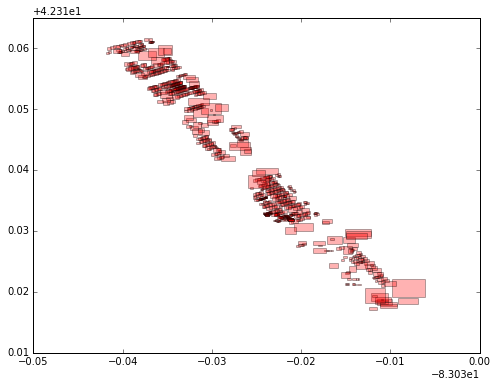

In [209]:
fig = plt.figure(figsize=(8,6))
for box in bboxes[0:1000]:
    draw_screen_bbox(box, fig)
    
plt.xlim(-83.08,-83.03)
plt.ylim(42.32,42.375)
    
plt.show()